# 04 - Model Tuning (XGBoost)

This notebook performs hyperparameter tuning for the XGBoost model used in the Scania predictive maintenance project.

Goals:

- Reuse the engineered feature data (`train_vehicle_features.csv`, `validation_vehicle_features.csv`, `test_vehicle_features.csv`)
- Run a small but meaningful hyperparameter search for XGBoost
- Evaluate the tuned model on TRAIN, VALIDATION, and TEST
- Plot ROC and Precision–Recall curves
- Compare tuned model metrics to the baseline model from `03_model_training.ipynb`

### Imports

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)

import matplotlib.pyplot as plt

### Load feature data

In [2]:
# Assuming these CSVs are in the current working directory
train_path = "train_vehicle_features.csv"
val_path = "validation_vehicle_features.csv"
test_path = "test_vehicle_features.csv"

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

Train shape: (23550, 577)
Validation shape: (5046, 577)
Test shape: (5045, 577)


### Prepare X/y for each split

In [3]:
VEHICLE_COL = "vehicle_id"
TARGET_COL = "in_study_repair"

feature_cols = [c for c in df_train.columns if c not in [VEHICLE_COL, TARGET_COL]]

X_train = df_train[feature_cols]
y_train = df_train[TARGET_COL].astype(int)

X_val = df_val[feature_cols]
y_val = df_val[TARGET_COL].astype(int)

X_test = df_test[feature_cols]
y_test = df_test[TARGET_COL].astype(int)

print("Number of features:", len(feature_cols))
print("TRAIN target distribution:\n", y_train.value_counts(normalize=True))
print("VAL target distribution:\n", y_val.value_counts(normalize=True))
print("TEST target distribution:\n", y_test.value_counts(normalize=True))

Number of features: 575
TRAIN target distribution:
 0    0.903524
1    0.096476
Name: in_study_repair, dtype: float64
VAL target distribution:
 0    0.984939
1    0.015061
Name: in_study_repair, dtype: float64
TEST target distribution:
 0    0.988107
1    0.011893
Name: in_study_repair, dtype: float64


### Helper: evaluation + plots

In [4]:
def evaluate_model(model, X, y, split_name="SPLIT", threshold=0.5):
    """Compute and print metrics + confusion matrix + classification report."""
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    roc_auc = roc_auc_score(y, y_proba)
    pr_auc = average_precision_score(y, y_proba)

    print(f"=== {split_name} metrics ===")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC (Average Precision): {pr_auc:.4f}\n")

    cm = confusion_matrix(y, y_pred)
    print(f"Confusion matrix (threshold={threshold}):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y, y_pred, digits=4))

    return {"roc_auc": roc_auc, "pr_auc": pr_auc}


def plot_roc_and_pr(model, X, y, split_name="SPLIT"):
    """Plot ROC and Precision–Recall curves for a given split."""
    y_proba = model.predict_proba(X)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)

    # PR
    precision, recall, _ = precision_recall_curve(y, y_proba)
    pr_auc = average_precision_score(y, y_proba)

    plt.figure(figsize=(12, 4))

    # ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{split_name} ROC Curve")
    plt.legend()

    # PR curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AP = {pr_auc:.3f})")
    baseline = y.mean()
    plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline (pos rate = {baseline:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{split_name} Precision–Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Define hyperparameter search space

We’ll do a RandomizedSearchCV tuned for imbalanced classification.

We can also compute scale_pos_weight based on class imbalance in the training data.

In [5]:
# Compute scale_pos_weight ≈ (num_negative / num_positive)
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
scale_pos_weight = neg_count / pos_count
scale_pos_weight

# Base model (we'll override params via RandomizedSearchCV)
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",  # we will use PR-AUC as scoring in CV
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

# Hyperparameter search space
param_distributions = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "scale_pos_weight": [
        scale_pos_weight * 0.5,
        scale_pos_weight,
        scale_pos_weight * 1.5,
    ],
}

### Run RandomizedSearchCV
We’ll use PR-AUC (average_precision) on the training set with cross-validation.

This might take a bit of time, but with 20 iterations and 3-fold CV it should be manageable.

In [6]:
n_iter_search = 20

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=n_iter_search,
    scoring="average_precision",  # PR-AUC
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42,
)

random_search.fit(X_train, y_train)

print("Best CV score (PR-AUC):", random_search.best_score_)
print("Best parameters:")
random_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CV score (PR-AUC): 0.3174417231775793
Best parameters:


{'subsample': 0.7,
 'scale_pos_weight': 4.682658450704225,
 'n_estimators': 300,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

### Train final tuned model with best params

In [7]:
best_params = random_search.best_params_
print("Best params:", best_params)

xgb_tuned = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    **best_params,
)

xgb_tuned.fit(X_train, y_train)
print("Tuned model trained on full TRAIN set.")

Best params: {'subsample': 0.7, 'scale_pos_weight': 4.682658450704225, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Tuned model trained on full TRAIN set.
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=4, min_child_weight=7, n_estimators=300, scale_pos_weight=14.047975352112676, subsample=0.9; total time=  41.5s
[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, scale_pos_weight=14.047975352112676, subsample=0.7; total time=  45.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, scale_pos_weight=9.36531690140845, subsample=1.0; total time=  54.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=200, scale_pos_weight=9.36531690140845, subsample=0.7; total time=  40.6s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimator

### Evaluate tuned model (TRAIN, VAL, TEST)

In [8]:
metrics_train_tuned = evaluate_model(xgb_tuned, X_train, y_train, split_name="TRAIN (TUNED)")
metrics_val_tuned = evaluate_model(xgb_tuned, X_val, y_val, split_name="VALIDATION (TUNED)")
metrics_test_tuned = evaluate_model(xgb_tuned, X_test, y_test, split_name="TEST (TUNED)")

=== TRAIN (TUNED) metrics ===
ROC-AUC: 0.9994
PR-AUC (Average Precision): 0.9947

Confusion matrix (threshold=0.5):
[[21065   213]
 [   18  2254]]

Classification report:
              precision    recall  f1-score   support

           0     0.9991    0.9900    0.9945     21278
           1     0.9137    0.9921    0.9513      2272

    accuracy                         0.9902     23550
   macro avg     0.9564    0.9910    0.9729     23550
weighted avg     0.9909    0.9902    0.9904     23550

=== VALIDATION (TUNED) metrics ===
ROC-AUC: 0.6669
PR-AUC (Average Precision): 0.0417

Confusion matrix (threshold=0.5):
[[4405  565]
 [  54   22]]

Classification report:
              precision    recall  f1-score   support

           0     0.9879    0.8863    0.9344      4970
           1     0.0375    0.2895    0.0664        76

    accuracy                         0.8773      5046
   macro avg     0.5127    0.5879    0.5004      5046
weighted avg     0.9736    0.8773    0.9213      5046

===

### Plot ROC + PR curves for VAL and TEST

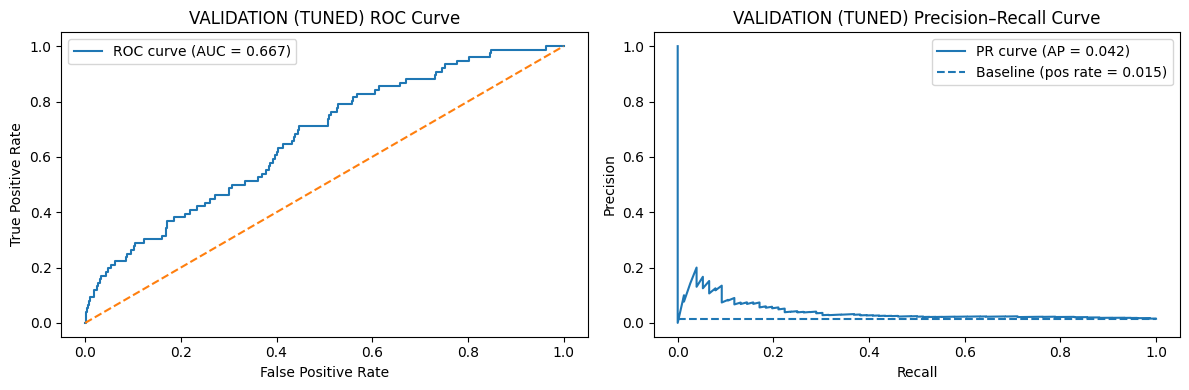

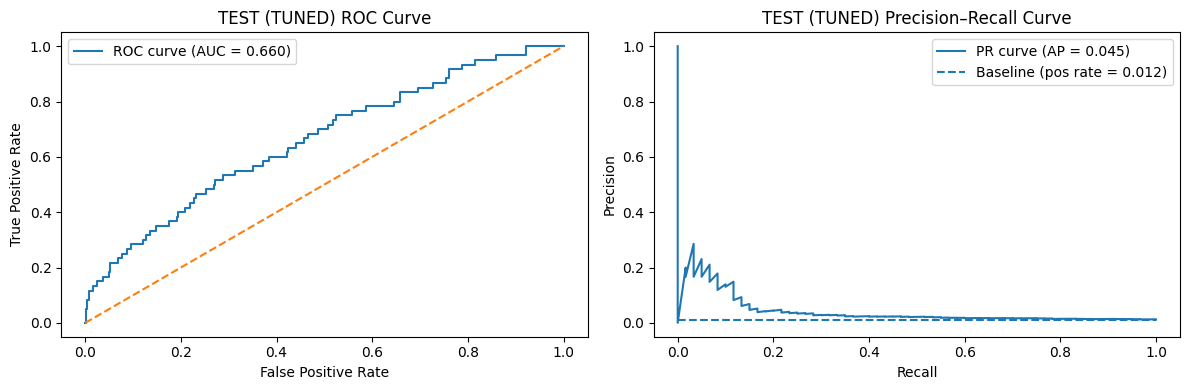

In [9]:
plot_roc_and_pr(xgb_tuned, X_val, y_val, split_name="VALIDATION (TUNED)")
plot_roc_and_pr(xgb_tuned, X_test, y_test, split_name="TEST (TUNED)")

### Compare with baseline metrics
Here we hard-code the baseline metrics from 03_model_training.ipynb and compare.

In [10]:
# Baseline metrics (from 03_model_training.ipynb)
baseline_val = {"roc_auc": 0.6997, "pr_auc": 0.0490}
baseline_test = {"roc_auc": 0.7020, "pr_auc": 0.0377}

print("=== VALIDATION comparison ===")
print(f"Baseline ROC-AUC: {baseline_val['roc_auc']:.4f}")
print(f"Tuned    ROC-AUC: {metrics_val_tuned['roc_auc']:.4f}")
print(f"Baseline PR-AUC : {baseline_val['pr_auc']:.4f}")
print(f"Tuned    PR-AUC : {metrics_val_tuned['pr_auc']:.44f}")

print("\n=== TEST comparison ===")
print(f"Baseline ROC-AUC: {baseline_test['roc_auc']:.4f}")
print(f"Tuned    ROC-AUC: {metrics_test_tuned['roc_auc']:.4f}")
print(f"Baseline PR-AUC : {baseline_test['pr_auc']:.4f}")
print(f"Tuned    PR-AUC : {metrics_test_tuned['pr_auc']:.4f}")

=== VALIDATION comparison ===
Baseline ROC-AUC: 0.6997
Tuned    ROC-AUC: 0.6669
Baseline PR-AUC : 0.0490
Tuned    PR-AUC : 0.04171119746032330571905433203028223942965269

=== TEST comparison ===
Baseline ROC-AUC: 0.7020
Tuned    ROC-AUC: 0.6597
Baseline PR-AUC : 0.0377
Tuned    PR-AUC : 0.0451


### Save and register tuned model

In [11]:
import joblib
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Model

# Save locally
tuned_model_filename = "xgb_pdm_finetuned.pkl"
joblib.dump(xgb_tuned, tuned_model_filename)
print("Saved tuned model to:", tuned_model_filename)

# Register in Azure ML
SUBSCRIPTION_ID = "52124f51-27f5-4c3c-99a9-fa716e4e8cfe"
RESOURCE_GROUP = "scania-pdm-rg"
WORKSPACE_NAME = "scania-pdm-ws"

ml_client = MLClient(
    DefaultAzureCredential(),
    SUBSCRIPTION_ID,
    RESOURCE_GROUP,
    WORKSPACE_NAME,
)

model = Model(
    name="scania-pdm-xgb-finetuned",
    path=tuned_model_filename,
    type="custom_model",
    description="Fine-tuned XGBoost model for Scania predictive maintenance",
    tags={"stage": "finetuned", "source": "04_model_tuning.ipynb"},
)

registered_model = ml_client.models.create_or_update(model)
print("Registered tuned model:", registered_model.name, "version:", registered_model.version)

Saved tuned model to: xgb_pdm_finetuned.pkl
Registered tuned model: scania-pdm-xgb-finetuned version: 1


Uploading xgb_pdm_finetuned.pkl (< 1 MB): 100%|██████████| 748k/748k [00:00<00:00, 16.2MB/s]


